In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Glucose distribution overtime after meal plot

In [4]:
gmr_df = pd.read_csv('../data/glucose_recordings.tsv', sep='\t')
gmr_df['time'] = pd.to_datetime(gmr_df['time'])

# Convert 'GlucoseValue' column to numeric, coerce errors to NaN
gmr_df['GlucoseValue'] = pd.to_numeric(gmr_df['GlucoseValue'], errors='coerce')
gmr_df = gmr_df.dropna(subset=['GlucoseValue'])
gmr_df['GlucoseValue'] = gmr_df['GlucoseValue'].astype(int)


gmr_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6146 entries, 0 to 6151
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Meal          6146 non-null   object        
 1   userID        6146 non-null   object        
 2   time          6146 non-null   datetime64[ns]
 3   GlucoseValue  6146 non-null   int32         
dtypes: datetime64[ns](1), int32(1), object(2)
memory usage: 216.1+ KB


In [19]:
unique_pairs = gmr_df[['userID', 'Meal']].drop_duplicates()
unique_pairs_list = list(unique_pairs.itertuples(index=False, name=None))

41 bar 2; 40 cf 1; 39 pb 1; 37 pb 1; 36 CF 2

<AxesSubplot: title={'center': 'Glucose Value vs Time for User 2133-039 Meal PB 1'}, xlabel='time'>

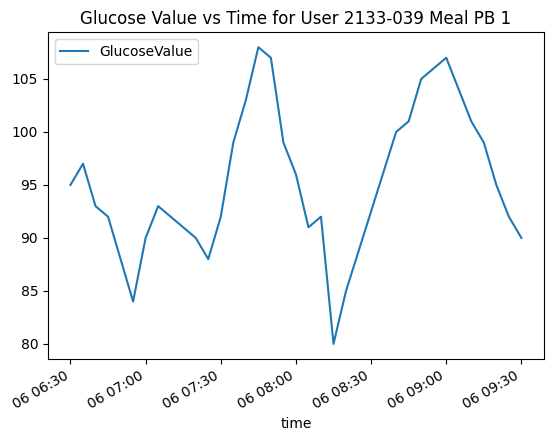

In [30]:
userID = "2133-039"
meal = "PB 1"

gmr_user1_meal1 = gmr_df[(gmr_df['userID'] == userID) & (gmr_df['Meal'] == meal)]
gmr_user1_meal1.plot(x='time', y='GlucoseValue', title=f'Glucose Value vs Time for User {userID} Meal {meal}')

In [2]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

MEAL_NUTRITION = {
    'PB': torch.tensor([430, 20, 51, 12, 12, 18]),
    'CF': torch.tensor([280, 2.5, 54, 33.2, 3.3, 11]),
    'Ba': torch.tensor([370, 18, 48, 19, 6, 9]),
}


# # Stack tensors to form a 2D tensor
# nutrition_matrix = torch.stack(list(MEAL_NUTRITION.values()))

# # Normalize column-wise by dividing by the maximum value in each column
# max_vals = nutrition_matrix.max(dim=0).values
# normalized_matrix = nutrition_matrix / max_vals

# # Update MEAL_NUTRITION with normalized values
# for i, key in enumerate(MEAL_NUTRITION):
#     MEAL_NUTRITION[key] = normalized_matrix[i] * 10


class GlucoseRecordings(Dataset):
    def __init__(self, gv_recordings_path):
        self.gmr_df = self._load_and_preprocess_data(gv_recordings_path)
        self.unique_pairs_list = self._get_unique_pairs()

    def _load_and_preprocess_data(self, path):
        """Load and preprocess glucose recordings data."""
        gmr_df = pd.read_csv(path, sep='\t')
        gmr_df['time'] = pd.to_datetime(gmr_df['time'])
        gmr_df['GlucoseValue'] = pd.to_numeric(gmr_df['GlucoseValue'], errors='coerce')
        gmr_df = gmr_df.dropna(subset=['GlucoseValue'])
        gmr_df['GlucoseValue'] = gmr_df['GlucoseValue'].astype(float)
        return gmr_df

    def _get_unique_pairs(self):
        """Get unique (userID, Meal) pairs."""
        unique_pairs = self.gmr_df[['userID', 'Meal']].drop_duplicates()
        return list(unique_pairs.itertuples(index=False, name=None))

    def __len__(self):
        return len(self.unique_pairs_list)

    def __getitem__(self, idx):
        userID, meal = self.unique_pairs_list[idx]
        user_meal_df = self.gmr_df[(self.gmr_df['userID'] == userID) & (self.gmr_df['Meal'] == meal)]
        
        t = torch.arange(len(user_meal_df), dtype=torch.float32)
        gv = torch.tensor(user_meal_df['GlucoseValue'].values, dtype=torch.float32)
        meal_nutritions = MEAL_NUTRITION[meal[:2]]

        return t, gv, meal_nutritions

    def get_data_loader(self, batch_size=1, shuffle=False):
        """Get DataLoader for the dataset."""
        return DataLoader(self, batch_size=batch_size, shuffle=shuffle)

# Callbacks

In [6]:

import seaborn as sns

class LossLogger(pl.Callback):
    def __init__(self):
        self.train_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.callback_metrics.get('train_loss')
        self.train_losses.append(train_loss.item())
    
    def plot_losses(self):
        if self.train_losses:
            sns.set(style="whitegrid")
            fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))

            # Plot training
            sns.lineplot(x=range(len(self.train_losses)), y=self.train_losses, ax=ax1, label='Train Loss', marker='o')
            ax1.set_xlabel('Epoch', fontsize=14)
            ax1.set_ylabel('Loss', fontsize=14)
            ax1.legend(fontsize=12)
            ax1.set_title('Training Loss (MSE) Over Epochs', fontsize=16)
            plt.tight_layout()
            plt.show()
        else:
            print("No data to plot.")


# Model

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt
import pytorch_lightning as pl

# class SimpleNutritionModel(nn.Module):
#     def __init__(self):
#         super().__init__()
        
#         # Initialize parameters for each nutrition (calories, fat, carb, sugar, fiber, protein)
#         self.t_meal = nn.Parameter(torch.tensor([10.0, 10.0, 10.0, 10.0, 10.0, 10.0], dtype=torch.float32))
        
#     def forward(self, t, meal_nutritions):
#         """
#         Args:
#             t: (meal_records_length)
#             meal_nutritions: (6)
#         """
#         t = t.unsqueeze(1) # (meal_records_length, 1)
#         result = torch.sum(meal_nutritions * torch.exp(-t/self.t_meal), dim=1) # (meal_records_length, 1)
#         return result # (meal_records_length, 1)

class GammaNutritionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Initialize parameters for each nutrition (calories, fat, carb, sugar, fiber, protein)
        self.k = nn.Parameter(torch.tensor([8.0, 8.0, 8.0, 8.0, 8.0, 8.0], dtype=torch.float32))
        self.theta = nn.Parameter(torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0], dtype=torch.float32))
    
    def forward(self, t, meal_nutritions):
        """
        Args:
            t: (meal_records_length)
            meal_nutritions: (6)
        """
        t = t.unsqueeze(1) # (meal_records_length, 1)
        gamma_dist = (t**(self.k - 1) * torch.exp(-t/self.theta)) / (self.theta**self.k * torch.exp(torch.lgamma(self.k)))
        result = torch.sum(meal_nutritions * gamma_dist, dim=1) # (meal_records_length, 1)
        return result # (meal_records_length, 1)

class GIModel(pl.LightningModule):
    def __init__(self, X0=0, Gb=75.0, Ib=15.0, optimizer_name='adam', lr=1e-3):
        super().__init__()
        self.optimizer_name = optimizer_name
        self.lr = lr

        # Initialize parameters 
        self.p1 = nn.Parameter(torch.tensor(0.05))
        self.p2 = nn.Parameter(torch.tensor(0.05))
        self.p3 = nn.Parameter(torch.tensor(0.05))
        self.p4 = nn.Parameter(torch.tensor(0.05))
        self.p5 = nn.Parameter(torch.tensor(95.0))
        self.p6 = nn.Parameter(torch.tensor(0.05))
        
        # Instantiate and register the GammaNutritionModel
        self.nutrition_model = GammaNutritionModel()
        self.Gb = Gb
        self.Ib = Ib
        self.X0 = X0
        self.loss_fn = nn.MSELoss()
    
    def gi_dynamics(self, t, y):
        G, X, I = y
        nutrition = self.nutrition_model(t.unsqueeze(0), self.meal_nutritions)
        dGdt = - X * G + self.p1 * (self.Gb - G) + nutrition
        dXdt = - self.p2 * X + self.p3 * (I - self.Ib)
        dIdt = self.p4 * torch.relu(G - self.p5) - self.p6 * (I - self.Ib)
        return torch.stack([dGdt.squeeze(), dXdt, dIdt])

    def forward(self, t, gv, meal_nutritions):
        """
        Args:
            t: (meal_records_length)
            gv: (meal_records_length)
            meal_nutritions: (meal_records_length, 6) 
        """
        self.meal_nutritions = meal_nutritions
        y0 = torch.tensor([gv[0], self.X0, self.Ib], dtype=torch.float32)
        
        result = odeint(self.gi_dynamics, y0, t, atol=1e-5, rtol=1e-5)
        G_pred, _, _ = result[:, 0], result[:, 1], result[:, 2]
        return G_pred

    def training_step(self, batch, batch_idx):
        t, gv, meal_nutritions = batch
        t = t.squeeze() # (meal_records_length)
        gv = gv.squeeze() # (meal_records_length)
        meal_nutritions = meal_nutritions.squeeze(1) # (6, )

        # Predict the glucose value using the current parameters
        G_pred = self(t, gv, meal_nutritions)

        # Compute the loss
        loss = self.loss_fn(G_pred, gv.squeeze(0))
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        t, gv, meal_nutritions = batch
        t = t.squeeze()
        gv = gv.squeeze()
        meal_nutritions = meal_nutritions.squeeze(1)

        # Predict the glucose value using the current parameters
        G_pred = self(t, gv, meal_nutritions)

        # Compute the loss
        loss = self.loss_fn(G_pred, gv.squeeze(0))
        self.log('test_loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        if self.optimizer_name == 'adam':
            optimizer = optim.Adam(self.parameters(), lr=self.lr)
        elif self.optimizer_name == 'sgd':
            optimizer = optim.SGD(self.parameters(), lr=self.lr)
        return optimizer

    def plot_prediction(self, glucose_dataset, userID, meal, filename=None):
        """
        Plot the glucose values and predicted values.

        Args:
            glucose_dataset: The dataset containing:
                - t: Time values (meal_records_length)
                - gv: Glucose values (meal_records_length)
                - meal_nutritions: Nutrition values (6)
            userID: The user ID
            meal: The meal type
            filename: The filename to save the plot (default: None)
        """
        sns.set(style="whitegrid")

        fig, ax = plt.subplots(1, 1, figsize=(12, 6), facecolor='w')
        sns.lineplot(x=glucose_dataset[0].numpy(), y=glucose_dataset[1].numpy(), ax=ax, label='Glucose Value', color='b', alpha=0.7, lw=2, marker='o')
        sns.lineplot(x=glucose_dataset[0].numpy(), y=self(glucose_dataset[0], glucose_dataset[1], glucose_dataset[2]).detach().numpy(), ax=ax, label='Predicted Glucose Value', color='r', alpha=0.7, lw=2, marker='o')

        ax.set_xlabel('Time (days)', fontsize=14)
        ax.set_ylabel('Glucose Value', fontsize=14)
        ax.set_ylim(0, 200)
        ax.set_title(f'Glucose Value vs Predicted Glucose Value Over Time of {userID} after meal {meal}', fontsize=16)

        ax.yaxis.set_tick_params(length=0)
        ax.xaxis.set_tick_params(length=0)

        ax.grid(True, which='both', linestyle='-', linewidth=0.5, color='gray')

        legend = ax.legend(fontsize=12)
        legend.get_frame().set_alpha(0.5)

        plt.tight_layout()
        
        if filename:
            plt.savefig(filename)
        else:
            plt.show()

## Testing

In [3]:
glucose_dataset = GlucoseRecordings('../data/test.tsv')
glucose_dataloader = glucose_dataset.get_data_loader()

In [7]:
# Initial conditions
X0=0
Gb=75.0
Ib=15.0

loss_logger = LossLogger()
model = GIModel()
trainer = pl.Trainer(max_epochs=1, callbacks=[loss_logger])
trainer.fit(model, glucose_dataloader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type                | Params | Mode 
----------------------------------------------------------------
0 | nutrition_model | GammaNutritionModel | 12     | train
1 | loss_fn         | MSELoss             | 0      | train
  | other params    | n/a                 | 6      | n/a  
----------------------------------------------------------------
18        Trainable params
0         Non-trainable params
18        Total params
0.000     Total estimated model params size (MB)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\l

Epoch 0: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s, v_num=11, train_loss_step=5.37e+3, train_loss_epoch=7.75e+3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s, v_num=11, train_loss_step=5.37e+3, train_loss_epoch=7.75e+3]


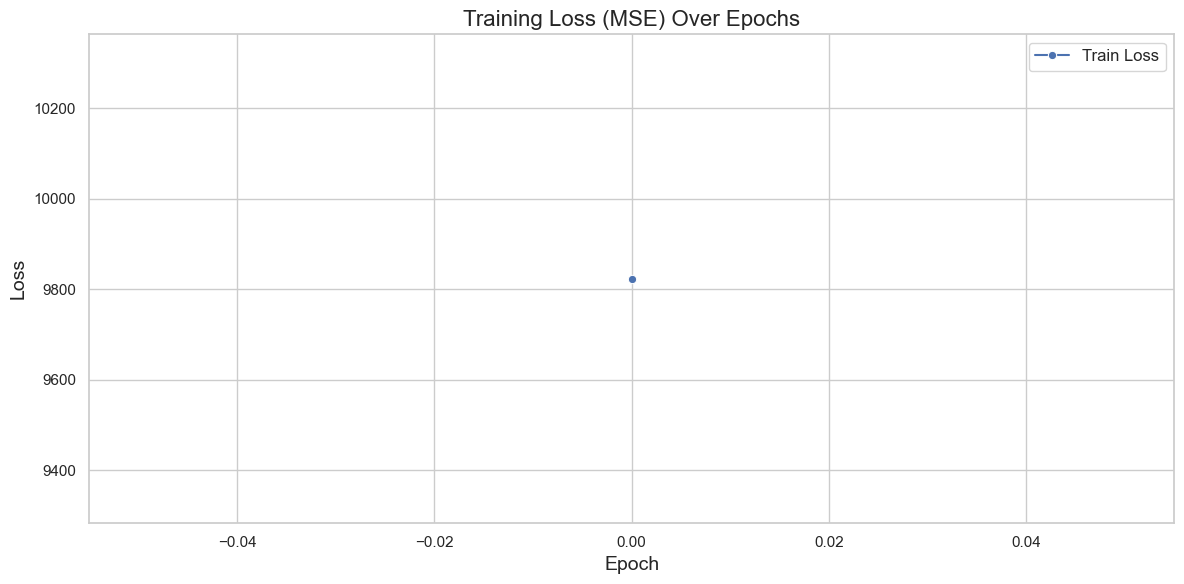

In [45]:
loss_logger.plot_losses()

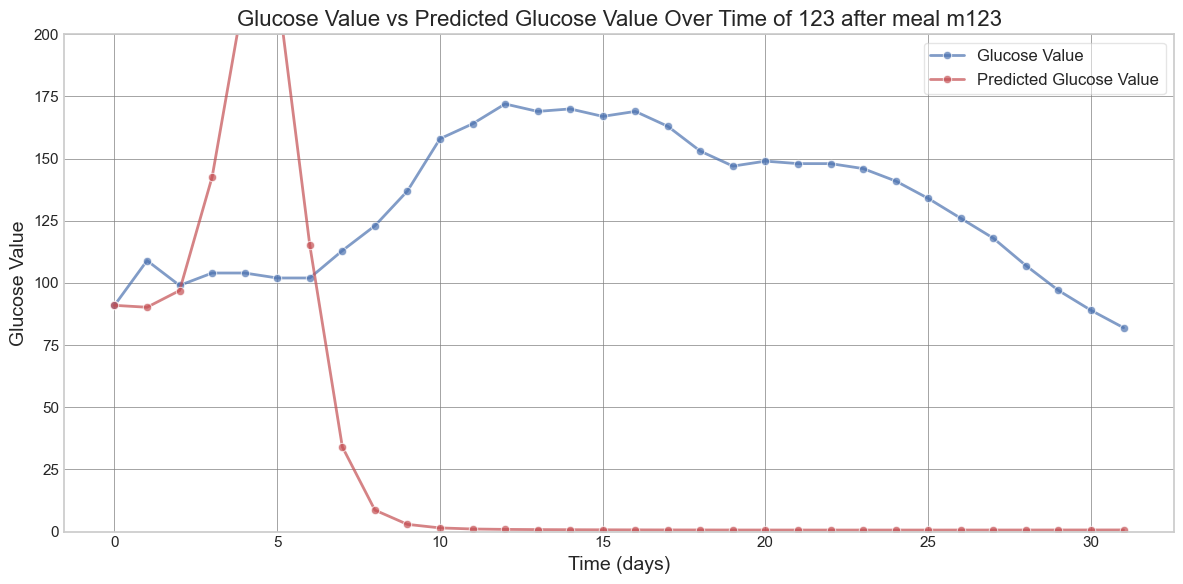

In [48]:
model.plot_prediction(glucose_dataset[0], '123', 'm123')

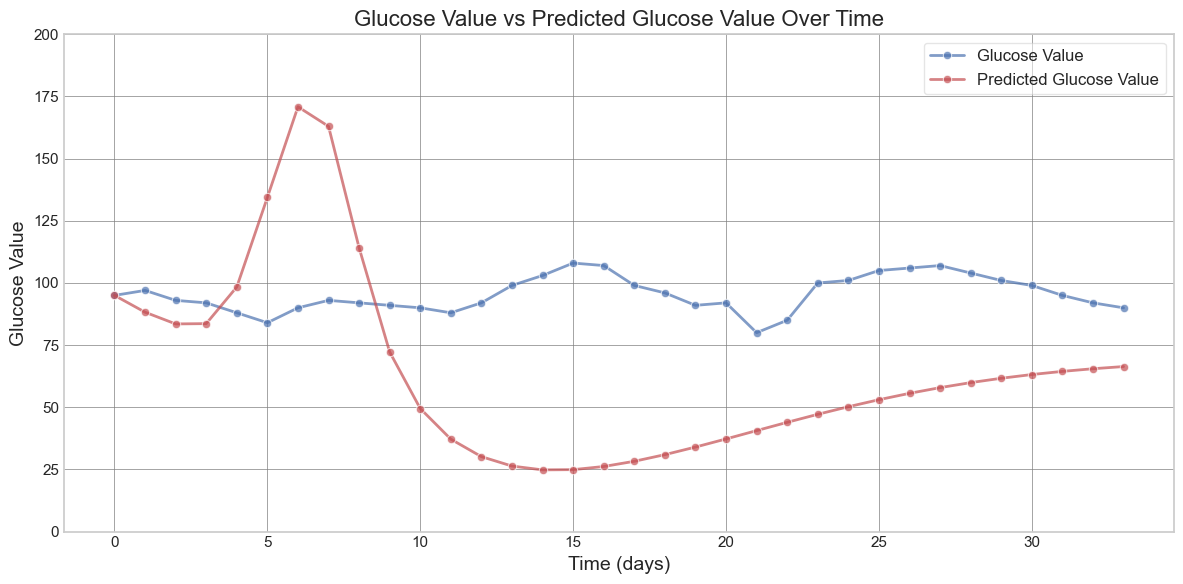

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid")

# Plot the curves for G(t) and G(t) predicted
fig, ax = plt.subplots(1, 1, figsize=(12, 6), facecolor='w')
sns.lineplot(x=glucose_dataset[2][0].numpy(), y=glucose_dataset[2][1].numpy(), ax=ax, label='Glucose Value', color='b', alpha=0.7, lw=2, marker='o')
sns.lineplot(x=glucose_dataset[2][0].numpy(), y=model(glucose_dataset[2][0], glucose_dataset[2][1], glucose_dataset[2][2]).detach().numpy(), ax=ax, label='Predicted Glucose Value', color='r', alpha=0.7, lw=2, marker='o')

# Set labels and title
ax.set_xlabel('Time (days)', fontsize=14)
ax.set_ylabel('Glucose Value', fontsize=14)
ax.set_ylim(0, 200)
ax.set_title('Glucose Value vs Predicted Glucose Value Over Time', fontsize=16)

# Customize ticks
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)

# Add grid with square style
ax.grid(True, which='both', linestyle='-', linewidth=0.5, color='gray')

# Add legend
legend = ax.legend(fontsize=12)
legend.get_frame().set_alpha(0.5)

# Show plot
plt.tight_layout()
plt.show()